In [2]:
from train import *
from addict import Dict
import logging
from utils.construct_tff import construct_real_tff
import matplotlib.pyplot as plt
from utils.data_utils import get_loader
!export CUDA_VISIBLE_DEVICES=7

In [3]:
logger = logging.getLogger(__name__)

In [4]:
args = Dict()
args.model_type = 'ViT-B_16'
args.img_size = 224
args.pretrained_dir = 'checkpoint/ViT-B_16.npz'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device
args.local_rank = -1
args.train_batch_size = 128 
args.eval_batch_size = 128

# args.dataset = 'inet1k_cats'
# args.dataset_dir = 'data/inet1k_classes/cats'
# ckpt_path = 'output/inet1k_cats-2023-10-02-22-19-15/inet1k_cats_final_ckpt.bin' 
# args.dataset = 'inet1k_birds'
# args.dataset_dir = 'data/inet1k_classes/birds'
# ckpt_path = 'output/inet1k_birds-2023-10-02-22-25-22/inet1k_birds_final_ckpt.bin'
args.dataset = 'inet1k_dogs'
args.dataset_dir = 'data/inet1k_classes/dogs'
ckpt_path = 'output/inet1k_dogs-2023-09-24-21-00-17/inet1k_dogs_final_ckpt.bin'
# args.dataset = 'inet1k_snakes'
# args.dataset_dir = 'data/inet1k_classes/snakes'
# ckpt_path = 'output/inet1k_snakes-2023-10-02-22-28-06/inet1k_snakes_final_ckpt.bin'
# args.dataset = 'inet1k_trucks'
# args.dataset_dir = 'data/inet1k_classes/trucks'
# ckpt_path = 'output/inet1k_trucks-2023-09-24-20-47-28/inet1k_trucks_final_ckpt.bin'

In [4]:
k_attn = 6144*2
l_attn = 2
n_attn = 768
tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
frame_cat = tffs.view(-1, n_attn)

In [5]:
redundancy = k_attn/384
redundancy

32.0

In [6]:
# percent of frames to keep
frame_percents = np.array([1, 0.9, 0.8, 0.5, 0.2])
frame_drops = 1 - frame_percents
print(frame_percents)
print(frame_drops)

[1.  0.9 0.8 0.5 0.2]
[0.  0.1 0.2 0.5 0.8]


In [5]:
args, model = setup(args)
ckpt = torch.load(ckpt_path)
for i in ckpt.keys():print(i)
print(model)

85.806346
transformer.embeddings.position_embeddings
transformer.embeddings.cls_token
transformer.embeddings.patch_embeddings.weight
transformer.embeddings.patch_embeddings.bias
transformer.encoder.layer.0.attention_norm.weight
transformer.encoder.layer.0.attention_norm.bias
transformer.encoder.layer.0.ffn_norm.weight
transformer.encoder.layer.0.ffn_norm.bias
transformer.encoder.layer.0.ffn.fc1.weight
transformer.encoder.layer.0.ffn.fc1.bias
transformer.encoder.layer.0.ffn.fc2.weight
transformer.encoder.layer.0.ffn.fc2.bias
transformer.encoder.layer.0.attn.query.weight
transformer.encoder.layer.0.attn.query.bias
transformer.encoder.layer.0.attn.key.weight
transformer.encoder.layer.0.attn.key.bias
transformer.encoder.layer.0.attn.value.weight
transformer.encoder.layer.0.attn.value.bias
transformer.encoder.layer.0.attn.out.weight
transformer.encoder.layer.0.attn.out.bias
transformer.encoder.layer.1.attention_norm.weight
transformer.encoder.layer.1.attention_norm.bias
transformer.encoder.

In [15]:
train_loader, test_loader = get_loader(args)

In [ ]:
num_itrs = 10
val_accs = []
norm_percents = []
with torch.no_grad():
    for frame_percent in frame_percents:
        frames_count = int(frame_percent * k_attn)
        print(frames_count)

        val_acc_i = 0
        norm_percent_i = 0
        for itr in range(num_itrs):
            args, model = setup(args)
            model.load_state_dict(torch.load(ckpt_path))
            norm_percent = 0
            weight_count = 0
            for (name, param) in model.named_parameters():
                if 'attn' in name:
                    if 'weight' in name:
                        # U, S, Vh = torch.linalg.svd(param)
                        # RotMat = U @ frame_cat
                        # new_projs = torch.matmul(tffs, RotMat.transpose(0,1) ) @ param
                        # new_norms = torch.norm(new_projs, dim=(1,2))
                        # new_norms_sorted, indices = torch.sort(new_norms, descending=True)
                        # norm_percent += torch.sqrt((new_norms_sorted[:frames_count]**2).sum()/(new_norms**2).sum())
                        # weight_count += 1

                        indices = torch.randperm(k_attn)
                        new_frames_filtered = tffs[indices[:frames_count]].view(-1,n_attn)
                        new_proj_mat = new_frames_filtered.transpose(0,1) @ new_frames_filtered

                        # new_projs = torch.matmul(new_frames_filtered, param)
                        # norm_percent += (torch.norm(new_projs) / torch.norm(param))**2
                        # weight_count += 1

                        param.data = new_proj_mat @ param.data 

            # norm_percents.append(norm_percent.item() /(weight_count))
            val_acc_i += valid(args, model, writer=None, test_loader=test_loader, global_step=0)
            # norm_percent_i += norm_percent.item()/weight_count
        val_accs.append(val_acc_i/num_itrs)
        # norm_percents.append(norm_percent_i/num_itrs)

        # print(f'{frame_percent = }, norm_percent = {norm_percents[-1]} {val_accs[-1] = }')
        print(f'{frame_percent = } {val_accs[-1] = }')

In [17]:
for frame_percent, val_acc in zip(frame_percents, val_accs):
    frames_count = int(frame_percent * k_attn)
    print(frame_percent, frames_count, val_acc)


1.0 12288 0.9932455251604188
0.9 11059 0.9923336710570754
0.8 9830 0.9516379601485985
0.5 6144 0.18753799392097265
0.2 2457 0.08419452887537994


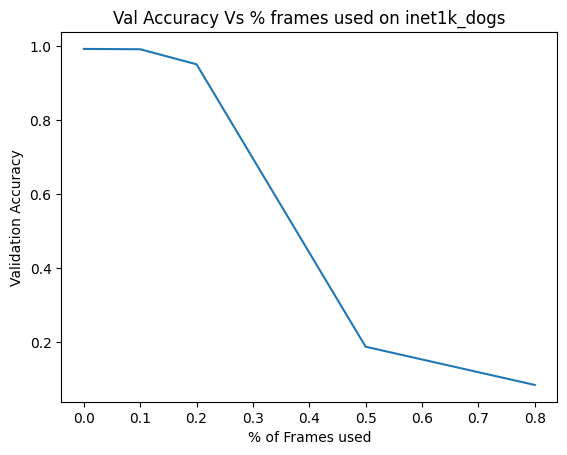

In [18]:
plt.plot(frame_drops, val_accs)
plt.title(f'Val Accuracy Vs % frames used on {args.dataset}')
plt.xlabel(f'% of Frames used')
plt.ylabel(f'Validation Accuracy')
plt.savefig(f'highSample_{args.dataset}_val_vs_frames.png')
plt.show()

# plt.plot(frame_percents, norm_percents)
# plt.title(f'% Norm retained Vs % frames used on {args.dataset}')
# plt.xlabel(f'% of Frames used')
# plt.ylabel(f'avg % of norm retained')
# plt.savefig(f'{args.dataset}_norm_vs_frames.png')
# plt.show()
# 
# plt.plot(norm_percents, val_accs)
# plt.title(f'Val accuracy Vs % Norm retained on {args.dataset}')
# plt.xlabel(f'avg % of norm retained')
# plt.ylabel(f'Validation accuracy')
# plt.savefig(f'{args.dataset}_Val_vs_norm.png')
# plt.show()